In [1]:
import tensorflow as tf

print(tf.__version__)

1.6.0


# CHAPTER 12. 심층 신경망 훈련

---
## 12.3 텐서플로 클러스터에서 신경망 병렬화하기
- 여러개의 신경망을 각기 다른 장치에 할당해 병렬화 시키는 방법
- 하나의 신경망을 여러 장치와 서버에서 훈련 시키는 방법

### 12.3.1 장치마다 하나의 신경망

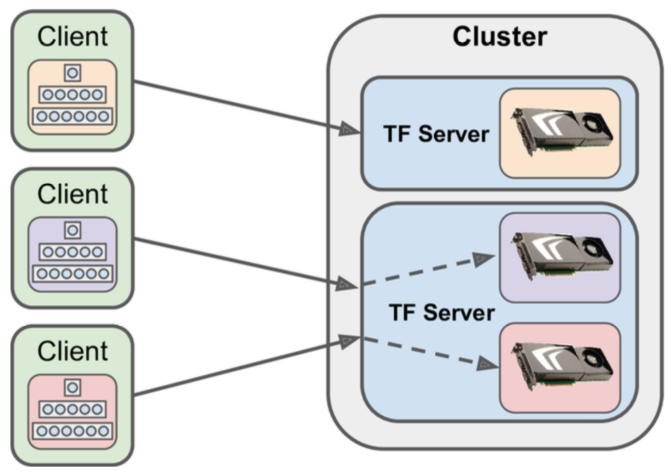

- 하나의 머신에 있는 하나의 장치를 사용하는 것과 똑같은 식으로 코드를 작성하는 것
- 세션을 만들 때 마스터 서버의 주소를 지정

#### 장점
- 하이퍼파라미터 튜닝을 위한 경우
    - 클러스터에 있는 각 장치는 자기만의 하이퍼파라미터 세팅된 모델로 훈련

### 12.3.2 그래프 내 복제와 그래프 간 복제 (Replication)
- 여러 신경망을 다른 장치에 배치하여 신경망의 대규모 앙상블 훈련을 쉽게 병렬화
- 신경망의 앙상블을 다루는 두 가지 큰 접근 방식
    - 그래프 내 복제
    - 그래프 간 복제
 
#### 앙상블 (7장 참고)
- 여러개의 모델을 학습시켜 그 모델들의 예측결과들을 이용해 하나의 모델보다 더 나은 값을 예측하는 방법

### 그래프 내 복제
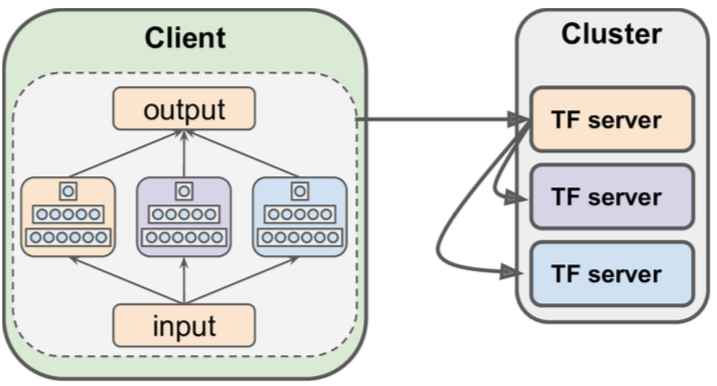

- 각각 다른 장치에 할당된 모든 신경망을 담는 하나의 큰 그래프를 생성
    - 모든 신경망으로부터 각각의 예측을 모으는 계산도 포함
- 클러스터에 있는 한 서버에서 세션을 만들고 모든 계산을 다른 서버에 위임
    - 모든 계산이 완료 될 때까지 대기

### 그래프 간 복제
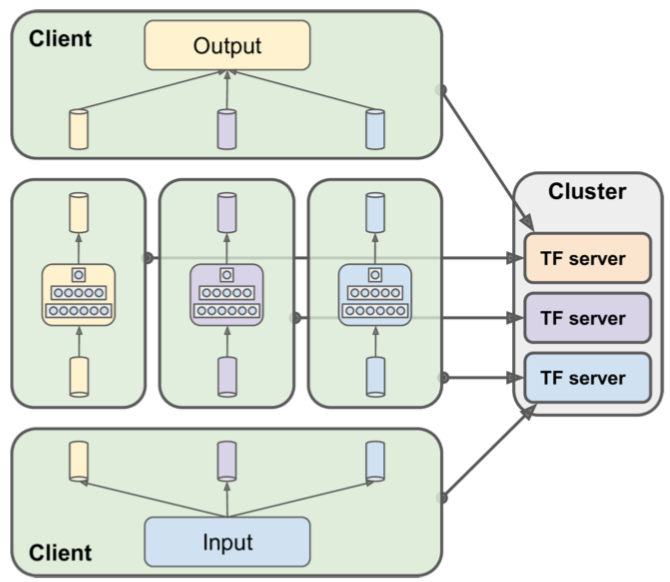

- 각 신경망을 독립된 그래프로 만들고 이 그래프 사이의 동기화를 관리하며 결과 출력
- Queue를 사용하여 그래프를 조율
- 일련의 클라이언트가 전용 입력 큐에서 읽고 예측 큐에 결과를 넣는 식으로 각기 하나의 신경망을 관리
    - 다른 클라이언트가 입력 데이터를 읽어 모든 입력 큐에 데이터를 넣는 일을 담당(모든 큐에 입력을 복제)
    - 최종 클라이언트가 하나가 각 예측 큐에서 예측을 읽어 모은 다음 앙상블의 에측을 만듦

### 장.단점
- 그래프 내 복제
    - 여러 클라이언트와 큐를 관리할 필요 없음
    - 구현하기 간단
- 그래프 간 복제
    - 유연하게 모델 관리가 가능
    - 예를 들어, 하나의 신경망이 문제를 일으킨 경우 앙상블이 실패하지 않도록 할 수 있음
        - run()함수 실행 시에 타임 아웃을 지정

In [ ]:
tf.reset_default_graph()

q = tf.FIFOQueue(capacity=10, dtypes=[tf.float32], shapes=[()])
v = tf.placeholder(tf.float32)
enqueue = q.enqueue([v])
dequeue = q.dequeue()
output = dequeue + 1

config = tf.ConfigProto()

with tf.Session(config=config) as sess:
    sess.run(enqueue, feed_dict={v: 1.0})
    sess.run(enqueue, feed_dict={v: 2.0})
    sess.run(enqueue, feed_dict={v: 3.0})
    print(sess.run(output))
    print(sess.run(output))
    print(sess.run(output))
    
    run_option = tf.RunOptions() #run() 함수에서 Option을 설정하는 방법
    run_option.timeout_in_ms = 1000 #1초 타임 아웃
    
    try:
        print(sess.run(output, options=run_option))
        #print(sess.run(output))
    except tf.errors.DeadlineExceededError as ex:
        print("dequeue 타임 아웃")

2.0
3.0
4.0


In [2]:
tf.reset_default_graph()

q = tf.FIFOQueue(capacity=10, dtypes=[tf.float32], shapes=[()])
v = tf.placeholder(tf.float32)
enqueue = q.enqueue([v])
dequeue = q.dequeue()
output = dequeue + 1

config = tf.ConfigProto()
config.operation_timeout_in_ms = 1000 # 1초 타임 아웃, 세션에서 타임아웃을 지정하여 어떤 연산이라도 타임아웃 시간 보다 오래 걸리면 타임 아웃

with tf.Session(config=config) as sess:
    sess.run(enqueue, feed_dict={v: 1.0})
    sess.run(enqueue, feed_dict={v: 2.0})
    sess.run(enqueue, feed_dict={v: 3.0})
    print(sess.run(output))
    print(sess.run(output))
    print(sess.run(output))
    try:
        print(sess.run(output))
    except tf.errors.DeadlineExceededError as ex:
        print("dequeue 타임 아웃")

2.0
3.0
4.0
dequeue 타임 아웃


### 12.3.3 모델 병렬화
- 모델을 여러부분으로 나누어 각 부분을 다른 장치에서 실행
    - 모델 병렬화는 매우 어렵고 신경망 모델의 구조에 의존적
    - 완전연결 신경망의 경우 이득이 없음
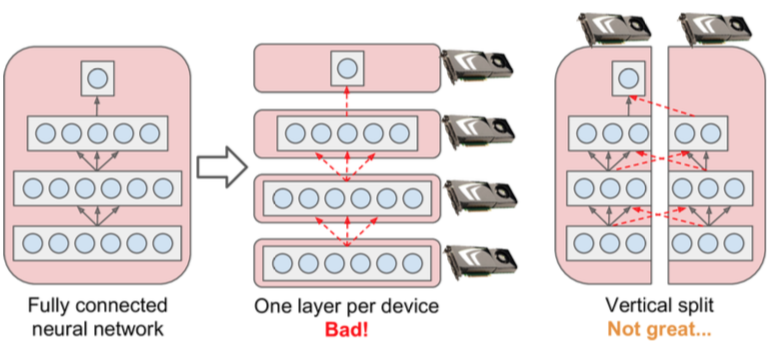

- 13장의 합성곱 신경망(CNN), 14장의 심층 순한 신경망(Deep RNN)의 경우 수직, 수평 분할할 경우 좋음
    - 하지만, 학습 속도를 높일 수 는 있지만 같은 머신의 장치끼리 통신하게 하는 등 특별한 조정과 튜닝이 필요
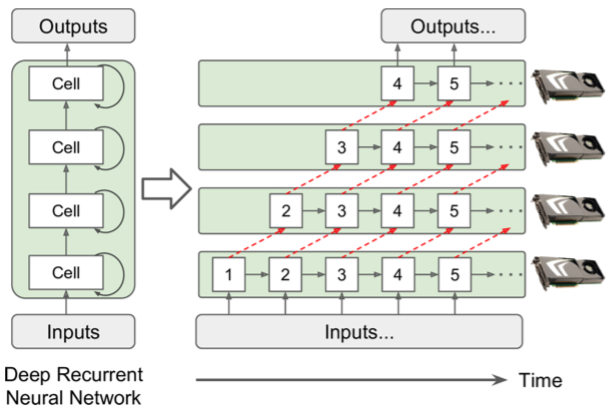

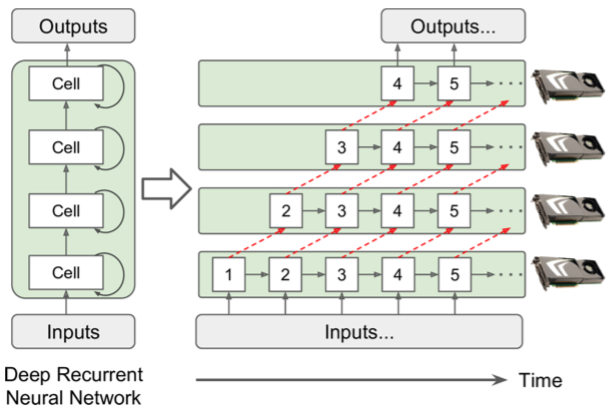

### 12.3.4 데이터 병렬화
- 신경망의 훈련을 병렬화 하는 또 다른 방법
- 각 장치에 모델을 복제하고, 각각 다른 미니배치를 상요해 모든 모델이 동시에 훈련 스텝을 실행
- 각 모델의 그래디언트를 취합하여 모델 파라미터를 업데이트
    - 방법은 동기 업데이트(Synchronous Update), 비동기 업데이트(Asynchronous Update)
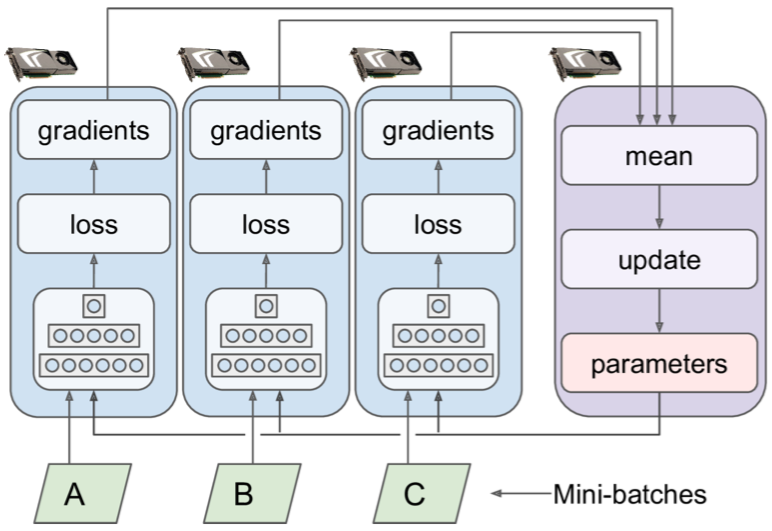

### 동기 업데이트(Synchronous Update)
- 그래디언트 수집기가 모든 그래디언트가 계산될 때까지 기다려서 평균을 계산 결과를 반영
- 한 복제 모델이 그래디언트 계산을 마치더라도 다음번 미니배치를 처리하기 전에 파라미터 업데이트도 기다림
    - 해결책) 전체 복제 모델에서 10%는 무시(즉, 20개의 복제모델이 실행하고 이 중에 가장 빠른 18개의 그래디언트만 취합하여 업데이트 수행) --> 여분의 복제 모델

### 비동기 업데이트(Asynchronous Update)
- 그래디언트 계산을 끝낼 때마다 즉시 이를 사용해 모델 파라미터를 업데이트(위 그림의 mean(평균) 단계가 없음)
    - 그래디언트 취합, 동기화 없음
    - 복제 모델들은 다른 복제 모델과 독립적으로 작동
- 실전에서는 잘 작동 하지만, 완벽히 작동하는 경우는 드뭄
    - 한 복제 모델의 파라미터 값에 기초해 그래디언트 값이 계산되어 다른 모델들에 의해 여러 번 업데이트될 것
    - 그 계산된 그래디언트가 다른 복제 모델에게는 정확한 방향을 가리킬 것이라는 보장이 없음
    - 낡은 그래디언트 문제
        - 수렴을 느리게 만들고 잡음과 흔들림을 발생시켜 훈련 알고리즘을 발산시킴
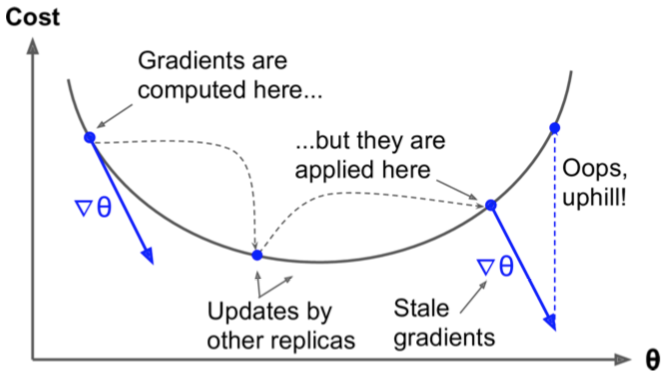

#### 낡은 그래디언트 문제를 줄이는 방법
1. 학습률(Learning rate)를 줄임
2. 낡은 그래디언트를 버리거나 크기를 줄임
3. 미니배치 크기를 조절
4. 하나의 복제만 사용하여 처음 몇 번의 에포크를 시작(준비 단계)
    - 훈련 초기에 낡은 그래디언트가 영향을 끼치는 경향이 많기 때문

### 대역폭 포화
- 동기, 비동기 업데이트 사용할 때, 파라미터 서버에 모든 복제 모델로 모델 파라미터를 전송, 업데이트 이후에는 반대로 전달
- GPU 내부에서 데이터를 입력, 출력으로 데이터를 옮기는데 드는 시간 보다, 네트워크를 통하는 시간이 더 오래 걸림
    - 특히, 규모가 작고 매우 큰 훈련 세트에서 훈련되는 모델의 경우 단일 머신에서가 더 좋음

- 대역폭 포화를 감소시키는 방법
    - GPU를 한 서버에 설치하여 불필요한 네트워크 연결을 회피
    - 여러대의 파라미터 서버에 파라미터를 분산 시켜 하나의 서버에 대역폭이 몰리는 것을 회피
    - 모델 파라미터의 실수 정밀도를 32비트(tf.float32)에서 16비트(tf.float16)으로 감소
        - 모델의 성능에 크게 영향을 끼치지 않고, 데이터의 양을 절반으로 줄임

###  12.4 연습문제

### 1. Tensorflow-GPU 실행할 때 CUDA_ERROR_OUT_OF_MEMORY 에러가 난 이유와 해결책
- 텐서플로 프로세스가 시작될 때 접근 할 수 있는 모든 GPU 장치의 가능한 모든 메모리를 점유
- 따라서, 이전에 다른 프로세스에서 하나의 GPU 장치에 있는 메모리를 점유했기 때문
- ConfigProto 객체를 생성해 gpu_options.per_process_gpu_memory_fraction 옵션으로 점유할 비율을 미리 선정
- 혹은, gpu_options.allow_growth를 true로 설정하여 텐서플로우가 필요 할때만 메모리를 점유하도록 설정
    - Session에서 적용하는 방법
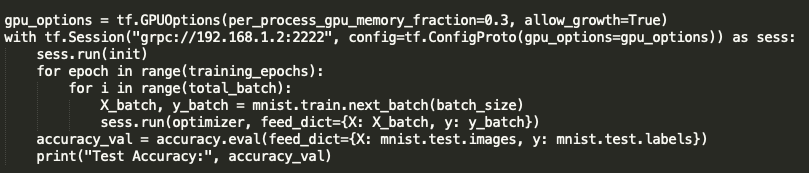

- clustering.py clustering 지정 시에 사용 하는 방법
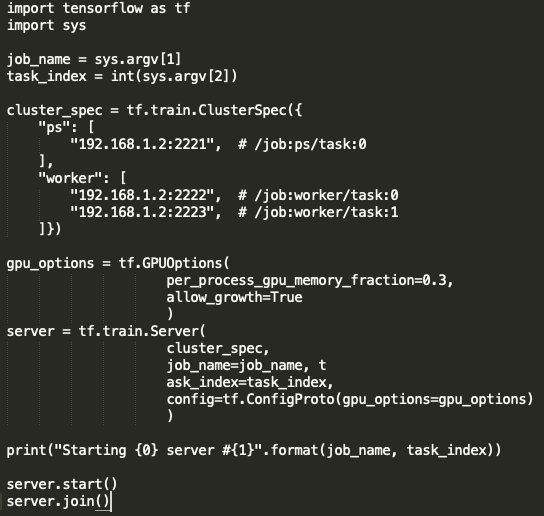

### 2. 장치에 연산을 할당하는 것과 배치하는 것 사이에 어떤 차이?
- 연산을 장치에 할당 하는 것은 연산이 배치 될 곳을 tensorflow에게 알려 주는 것
- 연산의 할당과 연산의 배치의 차이
    - 할당은 텐서플로우에게 요청하는 것
    - 배치는 실제로 텐서플로우가 수행하는 것

### 3. GPU 버전의 텐서플로를 기본 배치를 사용해 실행한다면 모든 연산이 첫 번째 GPU에 배치 될까요?
- 기본적으로 기본 배치를 사용해 실행하고 연산이 모두 첫 번째 GPU에 배치될 것
- python DNN.py 

### 4. 어떤 변수를 "/gpu:0"에 할당한다면 "/gpu:1"나 "/cpu:0" 에서 배치된 연산이 이를 사용 가능? 또 다른 서버의 장치에서도 할당된 연산을 사용 가능?
- 동일한 클러스터에 속해 있는 경우에만 할당된 변수를 가져다 사용이 가능
- 텐서플로우는 장치 간에 변수의 값을 전달하기 위한 적절한 연산을 자동으로 추가할 것

### 5. 같은 장치에 배치된 두 연산이 동시에 실행 가능?
- 같은 장치에 배치된 두 연산은 동시에 실행 가능
    - 텐서플로우는 다른 연산의 출력에 의존하는 연산이 없다면 자동으로 동시에 연산을 실행
    - 병렬 스레드에서 여러개의 세션을 시작하고자 할 경우, 각 세션은 독립적이기 때문에 실행 가능

### 6. 제어 의존성이 무엇이고 언제 사용할 필요가 있나요?
- 의존하는 모든 연산이 실행되었음에도 불구하고 연산의 평가를 미루는 것이 좋을 때도 있음
- 메모리를 많이 사용하는 연산의 경우, 그 값이 그래프의 후반에서 필요하다면 뒤로 미룸
    - 다른 연산에 필요한 메모리를 불필요하게 점유하는 것을 피하기 위해 마지막에 평가하도록 함

### 7. 텐서플로 클러스터에서 DNN 훈련 후 Saver 객체를 사용해 모델을 저장하지 않은 경우에, 학습된 모델은 잃은 것일까요?
- 분산 텐서플로우에서는 변수값이 클러스터에서 관리되는 컨테이너에 있으므로 세션을 닫고 클라이언트 프로그램을 종료하더라도 여전히 남음
- 클러스터에 대해 새 세션을 열고 모델을 저장하면 됨
    - 변수 초기화나 이전 모델을 복원하지 말아야 함

### 8. DNN을 다른 하이퍼파라미터를 사용해 병렬로 훈련
### 9. 모델 세 개를 사용하여 하나의 그래프에 이를 포함 시키고 각 DNN이 다른 장치에 실행 되도록 함
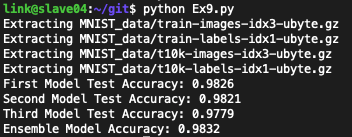
### 10. 그래프간 복제와 비동기 업데이트와 동기 업데이트 병렬화를 사용해 DNN을 훈련시켜보세요. 훈련 속도와 성능 차이는?